# Reverse Engineering: check if center, scale and part work as I understand it

In [1]:
#import libraries
from matplotlib import pyplot as plt
import cv2
import h5py
import numpy as np

In [2]:
#read train hdf5 datasets
with h5py.File('Semantic_Keypoints_Dataset_V6/drones_train.h5', 'r') as hdf_drones_train:
    center_drones_train = np.array(hdf_drones_train.get('center'))
    part_drones_train = np.array(hdf_drones_train.get('part'))
    scale_drones_train = np.array(hdf_drones_train.get('scale'))
    rotation_drones_train = np.array(hdf_drones_train.get('rotation'))
    translation_drones_train = np.array(hdf_drones_train.get('translation'))
    
#names of top files
drones_train_f = open('Semantic_Keypoints_Dataset_V6/drones_train.txt', 'r') 
drones_train_names = drones_train_f.read().splitlines()
drones_train_names_top = drones_train_names[0:5]


In [3]:
#indices of objects (matlab indices - 1):
classes_indexes_range = {"drone": range(0,8)}

original image size: (540, 960, 3)
Pads (lrtb):5, 5, 5, 5
bbox corners (padded): (331, 283); (412, 364)
This is a drone
Rotation matrix: 
[[ 0.174314  -0.952166   0.250985 ]
 [ 0.984575   0.172441  -0.0296145]
 [-0.0150822  0.252276   0.967538 ]]
Translation vector: 
[ 2.55106   0.612485 -1.02555 ]


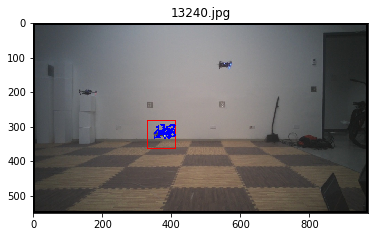

-------------------------------------------
original image size: (540, 960, 3)
Pads (lrtb):5, 5, 5, 5
bbox corners (padded): (693, 152); (782, 241)
This is a drone
Rotation matrix: 
[[ 0.58682   -0.764055   0.26807  ]
 [ 0.789123   0.613837   0.0221292]
 [-0.181459   0.198554   0.963145 ]]
Translation vector: 
[ 2.26998  -0.971031 -0.383086]


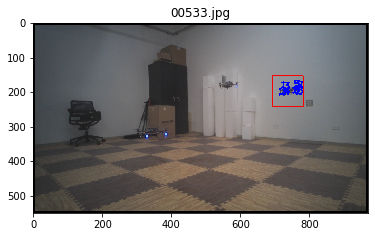

-------------------------------------------
original image size: (540, 960, 3)
Pads (lrtb):5, 5, 5, 5
bbox corners (padded): (219, 173); (309, 263)
This is a drone
Rotation matrix: 
[[-0.814109   0.505652   0.285557 ]
 [-0.5227    -0.852304   0.0190314]
 [ 0.253005  -0.133767   0.958173 ]]
Translation vector: 
[ 2.07934   0.873925 -0.4106  ]


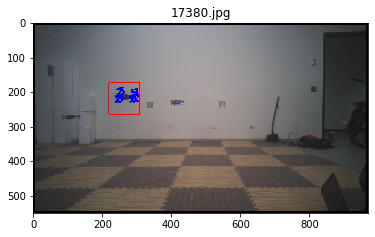

-------------------------------------------
original image size: (540, 960, 3)
Pads (lrtb):5, 5, 5, 5
bbox corners (padded): (295, 31); (401, 137)
This is a drone
Rotation matrix: 
[[ 0.74081    -0.634816    0.219568  ]
 [ 0.651862    0.758306   -0.00692895]
 [-0.162101    0.148261    0.975573  ]]
Translation vector: 
[1.86381   0.465845  0.0503667]


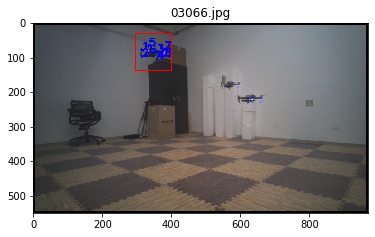

-------------------------------------------
original image size: (540, 960, 3)
Pads (lrtb):5, 5, 5, 5
bbox corners (padded): (606, 213); (691, 298)
This is a drone
Rotation matrix: 
[[ 0.0217282  -0.965326    0.26014   ]
 [ 0.999749    0.0195773  -0.0108566 ]
 [ 0.00538728  0.260311    0.96551   ]]
Translation vector: 
[ 2.31468  -0.637533 -0.636048]


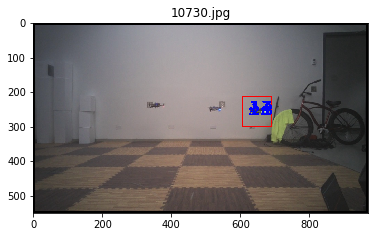

-------------------------------------------


In [4]:
for name in drones_train_names_top:
    #index of image in the dataset
    idx = drones_train_names_top.index(name)
    
    #read image in opencv
    img = cv2.imread('Semantic_Keypoints_Dataset_V6/image_raw_GT/'+name)
    img_colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #get image dimensions
    img_dimensions = img.shape
    print("original image size: "+str(img_dimensions))
    
    #compute bounding box coordinates (on unpadded image)
    start_point_bb_nopad = ((int)(center_drones_train[idx][0]-scale_drones_train[idx]*100), (int)(center_drones_train[idx][1]-scale_drones_train[idx]*100)) 
    end_point_bb_nopad = ((int)(center_drones_train[idx][0]+scale_drones_train[idx]*100), (int)(center_drones_train[idx][1]+scale_drones_train[idx]*100)) 
    #print("bbox corners: "+str(start_point_bb_nopad)+"; "+str(end_point_bb_nopad))
    
    #draw bounding box on unpadded image
    img_colors_rect_nopad = cv2.rectangle(img_colors, start_point_bb_nopad, end_point_bb_nopad, (255, 0, 0), 2)
    
    #compute padds
    margin = 5
    left_pad, right_pad, top_pad, bottom_pad = margin, margin, margin, margin
    if start_point_bb_nopad[0] < 0:
        left_pad = -start_point_bb_nopad[0] + margin
    if end_point_bb_nopad[0] > img_dimensions[1]:
        right_pad = end_point_bb_nopad[0] - img_dimensions[1] + margin
    if start_point_bb_nopad[1] < 0:
        top_pad = -start_point_bb_nopad[1] + margin
    if end_point_bb_nopad[1] > img_dimensions[0]:
        bottom_pad = end_point_bb_nopad[1] - img_dimensions[0] + margin
        
    print("Pads (lrtb):"+str(left_pad)+", "+str(right_pad)+", "+str(top_pad)+", "+str(bottom_pad))
    
    
    img_padded = cv2.copyMakeBorder(img_colors, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, None, 0)
    
    #compute bounding box coordinates (on padded image)
    start_point_bb_padded = (start_point_bb_nopad[0]+left_pad, start_point_bb_nopad[1]+top_pad)
    end_point_bb_padded = (end_point_bb_nopad[0]+left_pad, end_point_bb_nopad[1]+top_pad)
    print("bbox corners (padded): "+str(start_point_bb_padded)+"; "+str(end_point_bb_padded))

    #draw bounding box on unpadded image
    img_colors_rect_padded = cv2.rectangle(img_padded, start_point_bb_padded, end_point_bb_padded, (255, 0, 0), 2)
    
    #check indexes, and find class of object
    object_class=""
    for class_indexes in classes_indexes_range:
        if not (part_drones_train[idx][classes_indexes_range[class_indexes]]==np.full(part_drones_train[idx][classes_indexes_range[class_indexes]].shape, -1.)).all():
            #print("This is a "+class_indexes)
            object_class=class_indexes
            break
    print("This is a "+object_class)
    
    print("Rotation matrix: ")
    print(rotation_drones_train[idx])
    print("Translation vector: ")
    print(translation_drones_train[idx])
    
    #draw keypoints on image: 
    #print(part_drones_train[idx][classes_indexes_range[class_indexes]])
    first_kp_id = classes_indexes_range[class_indexes][0]
    for kp_index in classes_indexes_range[class_indexes]:
        trans_kp_index = kp_index - first_kp_id + 1
        if (part_drones_train[idx][kp_index]==np.full((2), -1.)).all():
            print("missing keypoint: "+str(trans_kp_index))
        else:
            kp_padded_np = part_drones_train[idx][kp_index] + np.array([left_pad, top_pad])
            kp_padded = ((int)(kp_padded_np[0]), (int)(kp_padded_np[1]))
            cv2.circle(img_colors_rect_padded, kp_padded, 2, (0, 0, 255), thickness=2, lineType=8, shift=0)
            cv2.putText(img_colors_rect_padded, str(trans_kp_index), kp_padded, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    #TODO take points one by one, if not -1 add to the image with the respective kp_index
    #TODO for i in 
    
    #plot image
    plt.imshow(img_colors_rect_padded)
    plt.title(name)
    plt.show()
    
    print("-------------------------------------------")